In [120]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [121]:
def partial_derivitave(inputs, outputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]

def cooling_law(time, temperature_environment, temperature_start, COOLING_RATE):
    return temperature_environment + (temperature_start - temperature_environment) * torch.exp(-COOLING_RATE * time)

Text(0, 0.5, 'Temperature (C)')

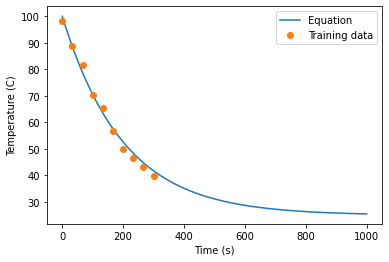

In [122]:
ENVIRONMENT_TEMPERATURE = 25
OBJECT_TEMPERATURE = 100
COOLING_RATE = 0.005
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 30000
LR = 1e-5

time_samples = torch.linspace(start=0, end=1000, steps=1000)
ground_truth_outputs = cooling_law(time=time_samples, temperature_environment=25, temperature_start=100, COOLING_RATE=0.005)

training_time_samples = torch.linspace(0, 300, 10)
training_outputs = cooling_law(training_time_samples, 25, 100, 0.005) + torch.randn(10) * 2

plt.plot(time_samples, ground_truth_outputs)
plt.plot(training_time_samples, training_outputs, 'o')
plt.legend(['Equation', 'Training data'])
plt.xlabel('Time (s)')
plt.ylabel('Temperature (C)')

In [123]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cooling_rate = nn.Parameter(torch.tensor([0.]), requires_grad=True)
        
        self.model = nn.Sequential(
            nn.Linear(1, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
        )
        
    def forward(self, x):
        return self.model(x)

In [124]:
model = PINN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
CRITERION = nn.MSELoss()

In [125]:
def PINN_loss():
    
    time_samples = torch.linspace(0, 1000, 1000).view(-1, 1).requires_grad_(True).to(DEVICE)
    temperature_model_predictions = model(time_samples)
    dTemp_by_dtime = partial_derivitave(time_samples, temperature_model_predictions)
    
    difference = model.cooling_rate*(ENVIRONMENT_TEMPERATURE-temperature_model_predictions) - dTemp_by_dtime
    mse = torch.mean(torch.square(difference))
    
    return mse

In [126]:
training_time_samples = training_time_samples.view(-1, 1).to(DEVICE)
training_outputs = training_outputs.view(-1, 1).to(DEVICE)

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    
    outputs = model(training_time_samples)
    loss_on_real_samples = CRITERION(outputs, training_outputs)
    loss_on_PINN_loss = PINN_loss()
    
    loss = loss_on_real_samples + loss_on_PINN_loss
    
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        print(f'Epoch: {epoch+1} | Loss: {loss.item()}')

Epoch: 1000 | Loss: 2543.41357421875
Epoch: 2000 | Loss: 2515.912841796875
Epoch: 3000 | Loss: 2451.59716796875
Epoch: 4000 | Loss: 2289.51123046875
Epoch: 5000 | Loss: 1754.6480712890625
Epoch: 6000 | Loss: 660.1830444335938
Epoch: 7000 | Loss: 100.27503967285156
Epoch: 8000 | Loss: 4.363009452819824
Epoch: 9000 | Loss: 1.0109213590621948
Epoch: 10000 | Loss: 0.8378696441650391
Epoch: 11000 | Loss: 0.784832239151001
Epoch: 12000 | Loss: 0.7509482502937317
Epoch: 13000 | Loss: 0.7389003038406372
Epoch: 14000 | Loss: 0.6614540815353394
Epoch: 15000 | Loss: 0.6167863607406616
Epoch: 16000 | Loss: 0.5788732767105103
Epoch: 17000 | Loss: 0.5345380902290344
Epoch: 18000 | Loss: 0.5109148621559143
Epoch: 19000 | Loss: 0.4804869592189789
Epoch: 20000 | Loss: 0.46834734082221985
Epoch: 21000 | Loss: 0.43727928400039673
Epoch: 22000 | Loss: 0.41838499903678894
Epoch: 23000 | Loss: 0.4049507677555084
Epoch: 24000 | Loss: 0.38719242811203003
Epoch: 25000 | Loss: 0.4144760072231293
Epoch: 26000 | 

Text(0, 0.5, 'Temperature (C)')

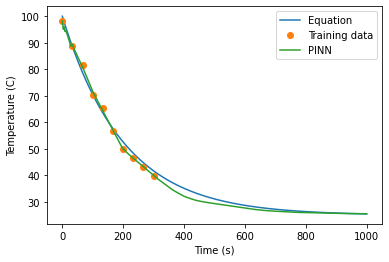

In [128]:
plt.plot(time_samples, ground_truth_outputs)
plt.plot(training_time_samples.cpu().detach(), training_outputs.cpu().detach(), 'o')
plt.plot(time_samples, model(time_samples.view(-1, 1).to(DEVICE)).cpu().detach())
plt.legend(['Equation', 'Training data', 'PINN'])
plt.xlabel('Time (s)')
plt.ylabel('Temperature (C)')

In [129]:
print(model.cooling_rate)

Parameter containing:
tensor([0.0048], device='cuda:0', requires_grad=True)
